In [1]:
%pwd

In [2]:
%cd ..

/home/rydevera3/data-science/umn_research/NCVX-Neural-Structural-Optimization


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
import os
import pandas as pd

# import problems to solve
import problems
import experiments
import train
import topo_api
import topo_physics
import models
import utils

from pygranso.private.getNvar import getNvarTorch
from pygranso.pygranso import pygranso
from pygranso.pygransoStruct import pygransoStruct

from scipy.ndimage import gaussian_filter

/home/rydevera3/data-science/umn_research/NCVX-Neural-Structural-Optimization/utils.py:25: UserWarning: sksparse.cholmod not installed. Falling back to SciPy/SuperLU, but simulations will be about twice as slow.
  warnings.warn(


# Running neural structural optimization with PyGranso 🧨

To check the validity of our new `torch` based code we will test the structural optimization with `torch.optim` optimizers.

### MBB Beam

The first problem that we will run is with the **MBB BEAM**.

In [4]:
def constrained_structural_optimization_function(model, ke, args, designs, losses):
    """
    Combined function for PyGranso for the structural optimization
    problem. The inputs will be the model that reparameterizes x as a function
    of a neural network. V0 is the initial volume, K is the global stiffness
    matrix and F is the forces that are applied in the problem.
    """
    # Initialize the model
    # In my version of the model it follows the similar behavior of the
    # tensorflow repository and only needs None to initialize and output
    # a first value of x
    logits = model(None)

    # kwargs for displacement
    kwargs = dict(
        penal=torch.tensor(args["penal"]),
        e_min=torch.tensor(args["young_min"]),
        e_0=torch.tensor(args["young"]),
        base='MATLAB',
    )
    x_phys = torch.sigmoid(logits)

    # Calculate the forces
    forces = topo_physics.calculate_forces(x_phys, args)

    # Calculate the u_matrix
    u_matrix = topo_physics.sparse_displace(
        x_phys, ke, args, forces, args["freedofs"], args["fixdofs"], **kwargs
    )

    # Calculate the compliance output
    compliance_output, _, _ = topo_physics.compliance(x_phys, u_matrix, ke, args, **kwargs)
    
#     import pdb; pdb.set_trace()

    # The loss is the sum of the compliance
    f = torch.abs(torch.sum(compliance_output))

    # Run this problem with no inequality constraints
    ci = None

    # Run this problem with no equality constraints
    ce = pygransoStruct()
    ce.c1 = 1e3 * (torch.mean(x_phys) - args['volfrac'])

    # Append updated physical density designs
    designs.append(
        x_phys
    )  # noqa

    return f, ci, ce

In [5]:
# Identify the problem
problem = problems.PROBLEMS_BY_NAME['multistory_building_32x64_0.5']

# Get the problem args
args = topo_api.specified_task(problem)
cnn_kwargs = None

# Trials
trials = []

for seed in range(59, 60):
    torch.random.manual_seed(seed)

    # Initialize the CNN Model
    if cnn_kwargs is not None:
        cnn_model = models.CNNModel(args, **cnn_kwargs)
    else:
        cnn_model = models.CNNModel(args)

    # Put the cnn model in training mode
    cnn_model.train()

    # Create the stiffness matrix
    ke = topo_physics.get_stiffness_matrix(
        young=args["young"],
        poisson=args["poisson"],
    )

    # Create the combined function and structural optimization
    # setup
    # Save the physical density designs & the losses
    designs = []
    losses = []
    # Combined function
    comb_fn = lambda model: constrained_structural_optimization_function(  # noqa
        model, ke, args, designs, losses
    )

    # Initalize the pygranso options
    opts = pygransoStruct()

    # Set the device
    opts.torch_device = torch.device('cpu')

    # Setup the intitial inputs for the solver
    nvar = getNvarTorch(cnn_model.parameters())
    opts.x0 = (
        torch.nn.utils.parameters_to_vector(cnn_model.parameters())
        .detach()
        .reshape(nvar, 1)
    )

    # Additional pygranso options
    opts.limited_mem_size = 20
    opts.double_precision = True
    opts.mu0 = 1.0
    opts.maxit = 500
    opts.print_frequency = 10
    opts.stat_l2_model = False
    opts.viol_eq_tol = 1e-6
    opts.opt_tol = 1e-4
    
    mHLF_obj = utils.HaltLog()
    halt_log_fn, get_log_fn = mHLF_obj.makeHaltLogFunctions(opts.maxit)

    #  Set PyGRANSO's logging function in opts
    opts.halt_log_fn = halt_log_fn

    # Main algorithm with logging enabled.
    soln = pygranso(var_spec=cnn_model, combined_fn=comb_fn, user_opts=opts)

    # GET THE HISTORY OF ITERATES
    # Even if an error is thrown, the log generated until the error can be
    # obtained by calling get_log_fn()
    log = get_log_fn()
    
    # Final structure
    designs_indexes = (pd.Series(log.fn_evals).cumsum() - 1).values.tolist()
    final_designs = [designs[i] for i in designs_indexes]
    
    trials.append((soln.final.f, pd.Series(log.f), final_designs))

/home/rydevera3/data-science/umn_research/NCVX-Neural-Structural-Optimization/topo_api.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "forces": torch.tensor(problem.forces.ravel()),
/home/rydevera3/.pyenv/versions/3.9.15/lib/python3.9/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
/home/rydevera3/.pyenv/versions/3.9.15/lib/python3.9/site-packages/torch/nn/functional.



╔═════ QP SOLVER NOTICE ════════════════════════════════════════════════════════════════════════╗
║  PyGRANSO requires a quadratic program (QP) solver that has a quadprog-compatible interface,  ║
║  the default is osqp. Users may provide their own wrapper for the QP solver.                  ║
║  To disable this notice, set opts.quadprog_info_msg = False                                   ║
╚═══════════════════════════════════════════════════════════════════════════════════════════════╝
═════════════════════════════════════════════════════════════════════════════════════════════════════════════════╗
PyGRANSO: A PyTorch-enabled port of GRANSO with auto-differentiation                                             ║ 
Version 1.2.0                                                                                                    ║ 
Licensed under the AGPLv3, Copyright (C) 2021-2022 Tim Mitchell and Buyun Liang                                  ║ 
═════════════════════════════════════════════

In [6]:
soln.final.f

43.75656982053592

In [7]:
best_trial = sorted(trials)[0]
best_trial[0]

43.75656982053592

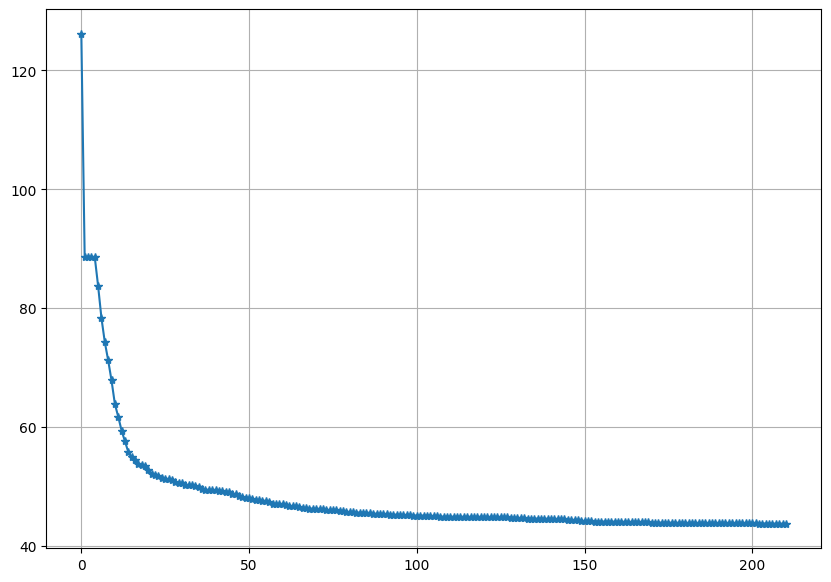

In [8]:
# Plot the loss
ax = best_trial[1].cummin().plot(figsize=(10, 7), marker='*')
ax.grid()

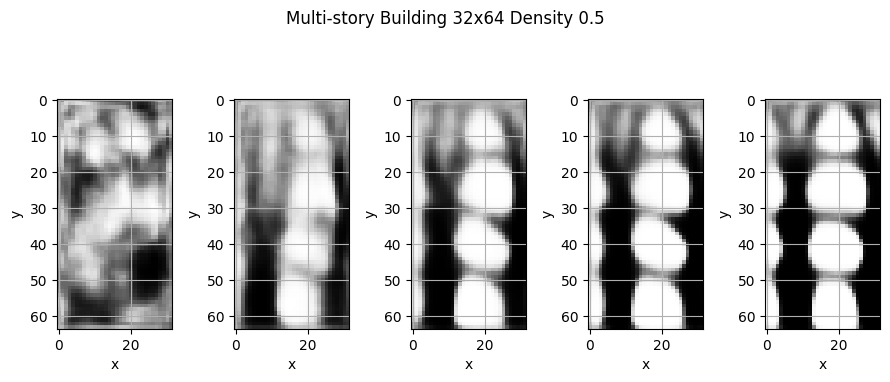

In [9]:
from scipy.ndimage import gaussian_filter

x_phys_images = [x_phys.detach() for x_phys in best_trial[2]]

# Plot the two structures together
fig, axes = plt.subplots(1, 5, figsize=(9, 4))
axes = axes.flatten()

for index, ax in zip([0, 10, 25, 50, -1], axes):
    pygranso_structure = x_phys_images[index]
    # pygranso
    ax.imshow(pygranso_structure, cmap='Greys')
    ax.grid()
    ax.set_xlabel('x')
    ax.set_ylabel('y')

    
fig.suptitle('Multi-story Building 32x64 Density 0.5')    
fig.tight_layout()